<h1 style='color: blue; font-size: 34px; font-weight: bold;'> Projeto Proposto 
</h1>
<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre o Covid19 no Brasil. </i>       
</p>  

# <font color='red' style='font-size: 40px;'> Problemática </font>
<hr style='border: 2px solid red;'>

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i>  Este projeto tem o intuito de estudar Modelos de Séries Temporais para previsão de informações sobre o Covid19 no Brasil.


</i> 
</p>  

<p style='font-size: 18px; line-height: 2; margin: 0px 0px; text-align: justify; text-indent: 0px;'>    
<i> 
</i> 
</p>  


# <font color='red' style='font-size: 40px;'> Bibliotecas Utilizadas </font>
<hr style='border: 2px solid red;'>

In [ ]:
## Bibliotecas De Manipulação de Dados e Visualização
import pandas as pd 
import geopandas as gpd
import builtins as builtins
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display, Image

## Bibliotecas de Modelagem Matemática e Estatística
import numpy as np
import scipy as sp 
import scipy.stats as stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# Bibliotecas de Manipulação de Tempo
import time
import datetime

# Bibiliotecas de Pré-Processamento e Seleção de Modelos
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Bibliotecas de Métricas de Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Parâmetros de Otimização
import warnings
%matplotlib inline
sns.set()
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = [10, 5]
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Tira os números do formato de Notação Científica
np.set_printoptions(suppress=True) # Tira os números do formato de Notação Científica em Numpy Arrays
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # Retira Future Warnings

# <font color='red' style='font-size: 40px;'> Funções </font>
<hr style='border: 2px solid red;'>

In [2]:
def plota_temporal(df, titulo, x, y):
    plt.figure(figsize=(10, 6))
    plt.plot(df, color='#1FB3E5', linewidth=2)
    plt.scatter(df.index, df, color='#1FB3E5', s=40)
    plt.title(f"{titulo}", fontsize=14)  # Define o título do gráfico e o tamanho da fonte
    plt.xlabel(f"{x}", fontsize=12)  # Define o rótulo do eixo x e o tamanho da fonte
    plt.ylabel(f"{y}", fontsize=12)  # Define o rótulo do eixo y e o tamanho da fonte
    plt.xticks(df.index, fontsize=10)  # Define o tamanho da fonte dos valores no eixo x
    plt.yticks(fontsize=10)  # Define o tamanho da fonte dos valores no eixo y
    plt.grid(True, linestyle=':', alpha=0.5)  # Adiciona linhas de grade
    plt.tight_layout()  # Ajusta automaticamente a posição dos elementos do gráfico
    plt.show()  # Exibe o gráfico

In [3]:
def ano_mes_dia(df):

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['year'] = df['timestamp'].dt.year
    df['month'] = df['timestamp'].dt.month
    df['day'] = df['timestamp'].dt.day


In [4]:
def separa_feature_target(target, dados):
    x = dados.drop(target, axis = 1)
    y = dados[[target]]
    return x, y

In [5]:
def separa_treino_teste_temporal(data, data_teste, dados):
    dados.sort_values(by = data, ascending = True, inplace = True)
    df_train = dados.loc[dados[data] < data_teste]
    df_test = dados.loc[dados[data] >= data_teste]

    return df_train, df_test

In [6]:
def discretiza_variavel(df, variavel_quant, variavel_qualit, bins, labels, right):
    df[variavel_qualit] = pd.cut(
        df[variavel_quant], 
        bins= bins, 
        labels= labels, 
        right = right
    )
    df.drop(variavel_quant, axis = 1, inplace = True)

In [7]:
def metricas(regressor, target, y_train, y_predict_train, y_test, y_predict_test, coeficiente_det_train, coeficiente_det_test):
    y_test[target].fillna(y_train[target].median(), inplace = True)

    mae_train = mean_absolute_error(y_predict_train, y_train)
    mse_train = mean_squared_error(y_predict_train, y_train)
    mape_train = mean_absolute_percentage_error(y_predict_train, y_train)
    metricas_treino = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_train, 'Erro_Medio_Absoluto':mae_train, 'Erro_Quadratico_Medio':mse_train, 'Media_Percentual_Absoluta_Erro':mape_train, 'Etapa':'treino', 'Regressor':regressor}, index = np.arange(1, 2))


    mae_test = mean_absolute_error(y_predict_test, y_test)
    mse_test = mean_squared_error(y_predict_test, y_test)
    mape_test = mean_absolute_percentage_error(y_predict_test, y_test)
    metricas_teste = pd.DataFrame({'Coeficiente de Determinação (R^2)':coeficiente_det_test, 'Erro_Medio_Absoluto':mae_test, 'Erro_Quadratico_Medio':mse_test, 'Media_Percentual_Absoluta_Erro':mape_test, 'Etapa':'teste', 'Regressor':regressor}, index = np.arange(1, 2))

    metricas_finais = pd.concat([metricas_treino, metricas_teste])

    return metricas_finais

def metricas_modelos_juntos(lista_modelos):
    metricas_modelos = pd.concat(lista_modelos).set_index('Regressor')
    return metricas_modelos


# <font color='red' style='font-size: 40px;'> 1) Leitura do Dataset </font>
<hr style='border: 2px solid red;'>

# <font color='green' style='font-size: 30px;'> 1.1) Descrição das Variáveis </font>
<hr style='border: 2px solid green;'>

### 1.1.1) Cases

1. **Date:** Data

2. **State:** Estado

3. **Name:** Nome do Estado

4. **Code:** Codigo da Cidade

5. **Cases:** Número de Casos

6. **Deaths:** Número de Mortes

### 1.1.2) Coordinates

1. **State Code:** Código do Estado

2. **City Code:** Código da Cidade

3. **City Name:** Nome da Cidade

4. **Lat:** Latitude

5. **Long:** Longitude


### 1.1.3) Populatiion

1. **Region:** Região do País

2. **State:** Estado

3. **City:** Nome da Cidade

4. **State Code:** OCódigo do Estado

5. **Population:** Número de Habitantes

In [27]:
df_cases = pd.read_csv('./data/brazil_covid19_cities.csv')
df_cases['city_code'] = df_cases['code'].astype(int)
df_cases['cases'] = df_cases['cases'].astype(int)

df_coordinates = pd.read_excel('./data/brazil_cities_coordinates.xlsx')
df_coordinates['city_code'] = df_coordinates['city_code'].astype(str).str[:-1].astype(int)

df_population = pd.read_excel('./data/brazil_population_2019.xlsx')

df_raw = (
    df_cases[['date', 'state', 'name', 'city_code', 'cases', 'deaths']]
    .merge(
        df_population.merge(df_coordinates[['city_code', 'lat', 'long']], on = 'city_code', how = 'left').drop(['state', 'city', 'state_code', 'health_region_code', 'health_region', 'Unnamed: 8'], axis = 1),
        on = 'city_code',
        how = 'inner'
    )
)

# <font color='red' style='font-size: 40px;'> 2) Análise Exploratória </font>
<hr style='border: 2px solid red;'>

In [42]:
df_raw_time_series = (
    df_raw.groupby(['date']).agg({
        "cases": "sum", 
        "deaths": "sum", 
    })
    .reset_index()
)

df_raw_time_series['tax_deaths_per_cases'] = df_raw_time_series['deaths']/df_raw_time_series['cases']*100
df_raw_time_series['tax_deaths_per_cases'] = df_raw_time_series['tax_deaths_per_cases'].fillna(0)
df_raw_time_series['date'] = pd.to_datetime(df_raw_time_series['date'])
df_raw_time_series.sort_values(by = 'date', ascending = True)


df_raw_time_series_states = (
    df_raw.groupby(['date', 'state']).agg({
        "cases": "sum", 
        "deaths": "sum", 
    })
    .reset_index()
)

df_raw_time_series_states['tax_deaths_per_cases'] = df_raw_time_series_states['deaths']/df_raw_time_series_states['cases']*100
df_raw_time_series_states['tax_deaths_per_cases'] = df_raw_time_series_states['tax_deaths_per_cases'].fillna(0)
df_raw_time_series_states['date'] = pd.to_datetime(df_raw_time_series_states['date'])
df_raw_time_series_states.sort_values(by = 'date', ascending = True)

df_raw_cross_section = (
    df_raw.groupby(['state']).agg({
        "cases": "sum", 
        "deaths": "sum", 
    })
    .reset_index()
)

df_raw_cross_section['tax_deaths_per_cases'] = df_raw_cross_section['deaths']/df_raw_cross_section['cases']*100
df_raw_cross_section['tax_deaths_per_cases'] = df_raw_cross_section['tax_deaths_per_cases'].fillna(0)


# <font color='green' style='font-size: 30px;'> 2.1) Quais estados concentram as maiores taxas de Morte/Casos no total? </font>
<hr style='border: 2px solid green;'>

> 1. O número de casos e mortes se concentra na Região Sudeste, mais especificamente em SP, entretanto, a Taxa de Mortalidade alcança os maiores níveis no RJ e em PE


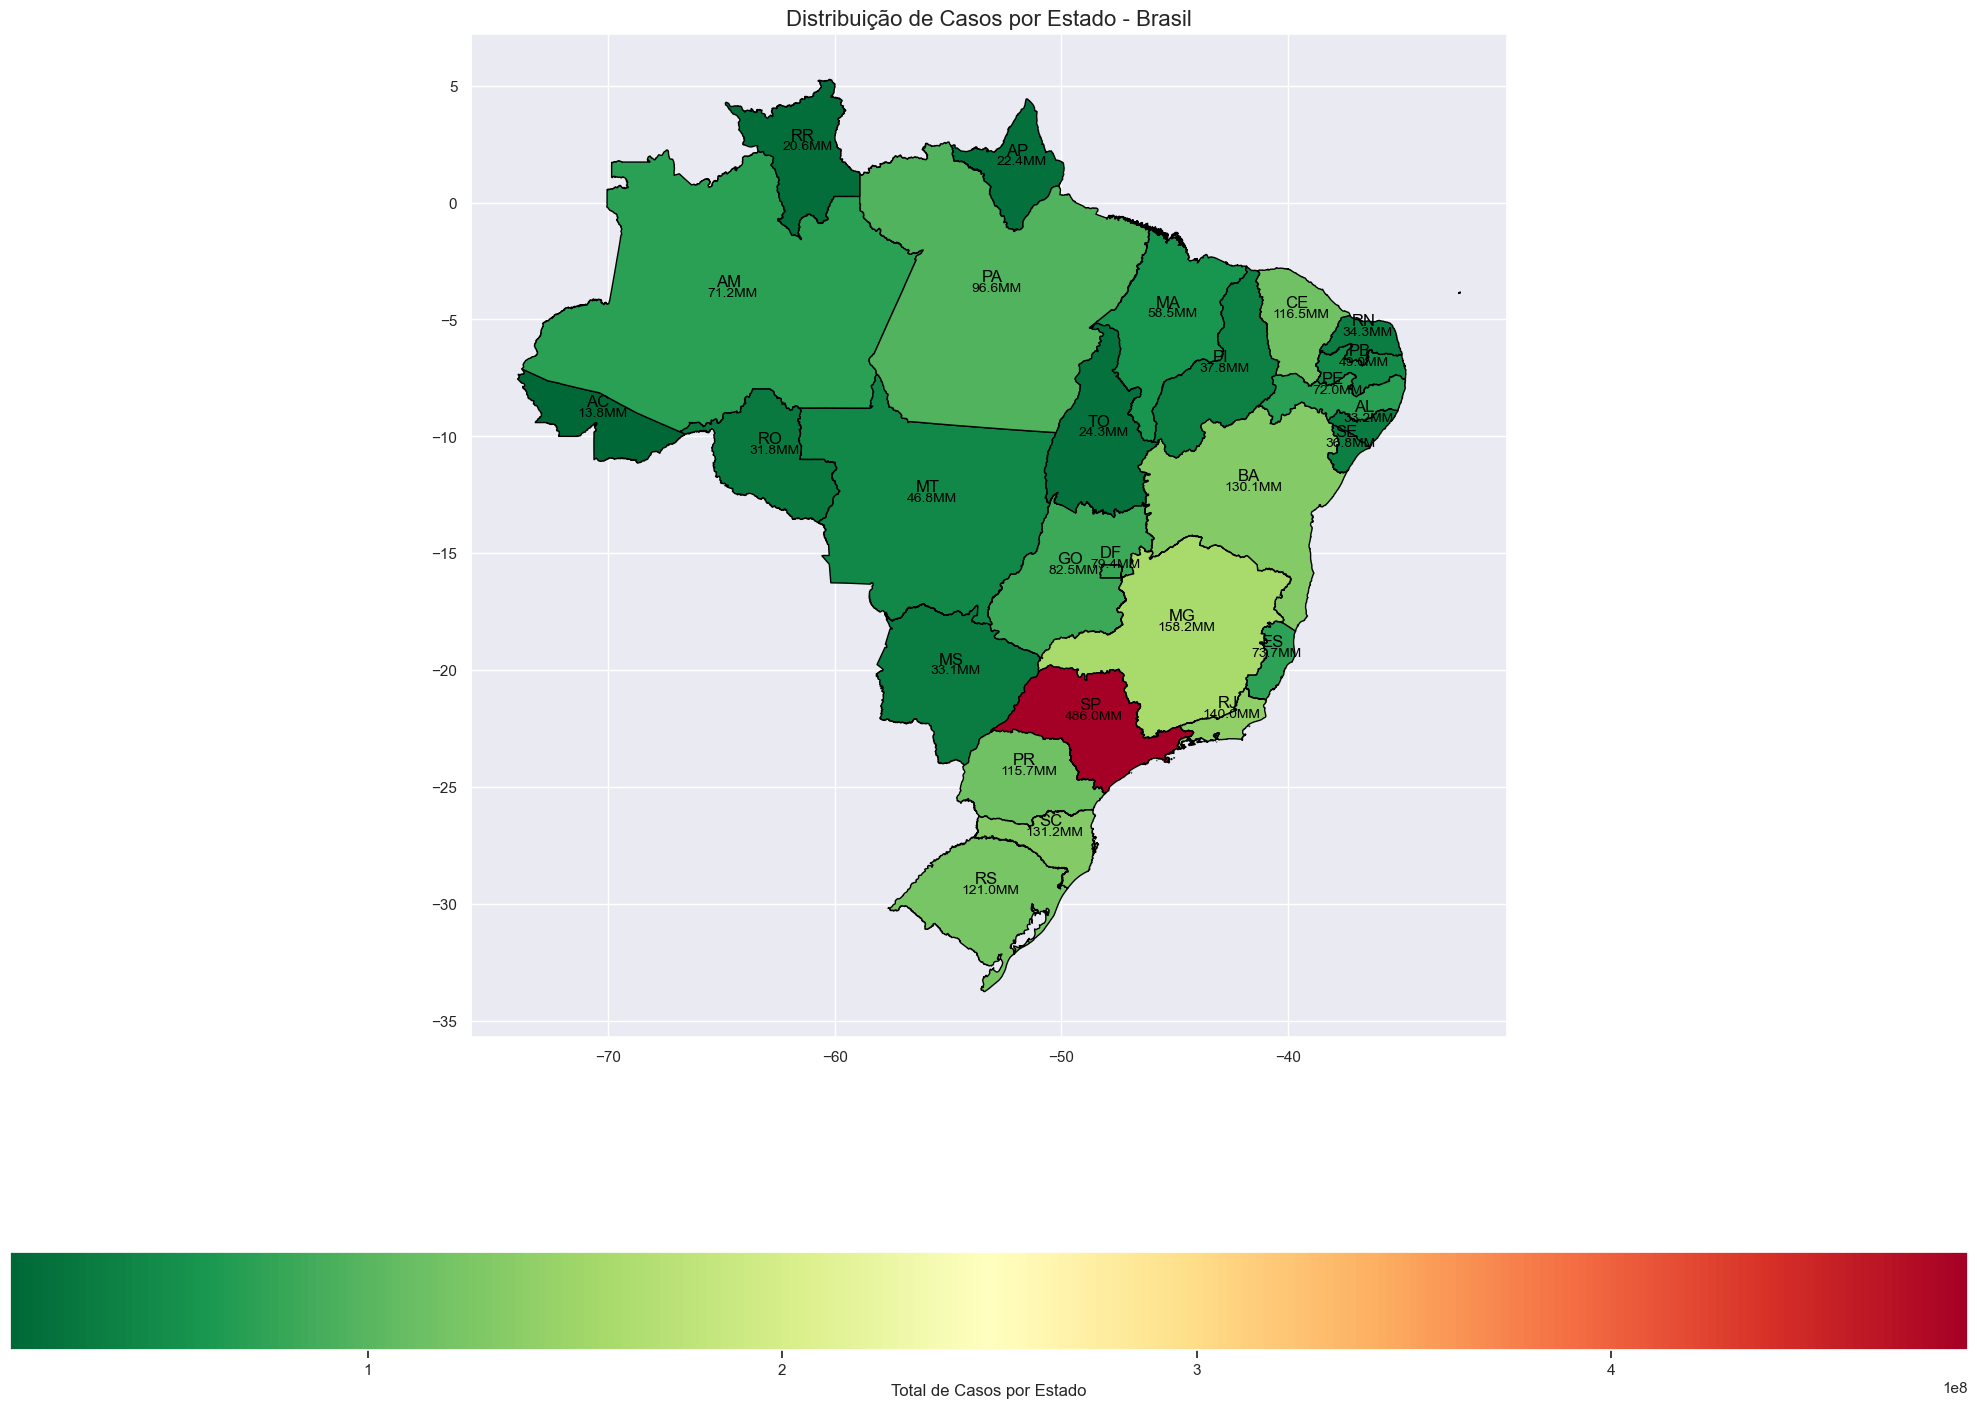

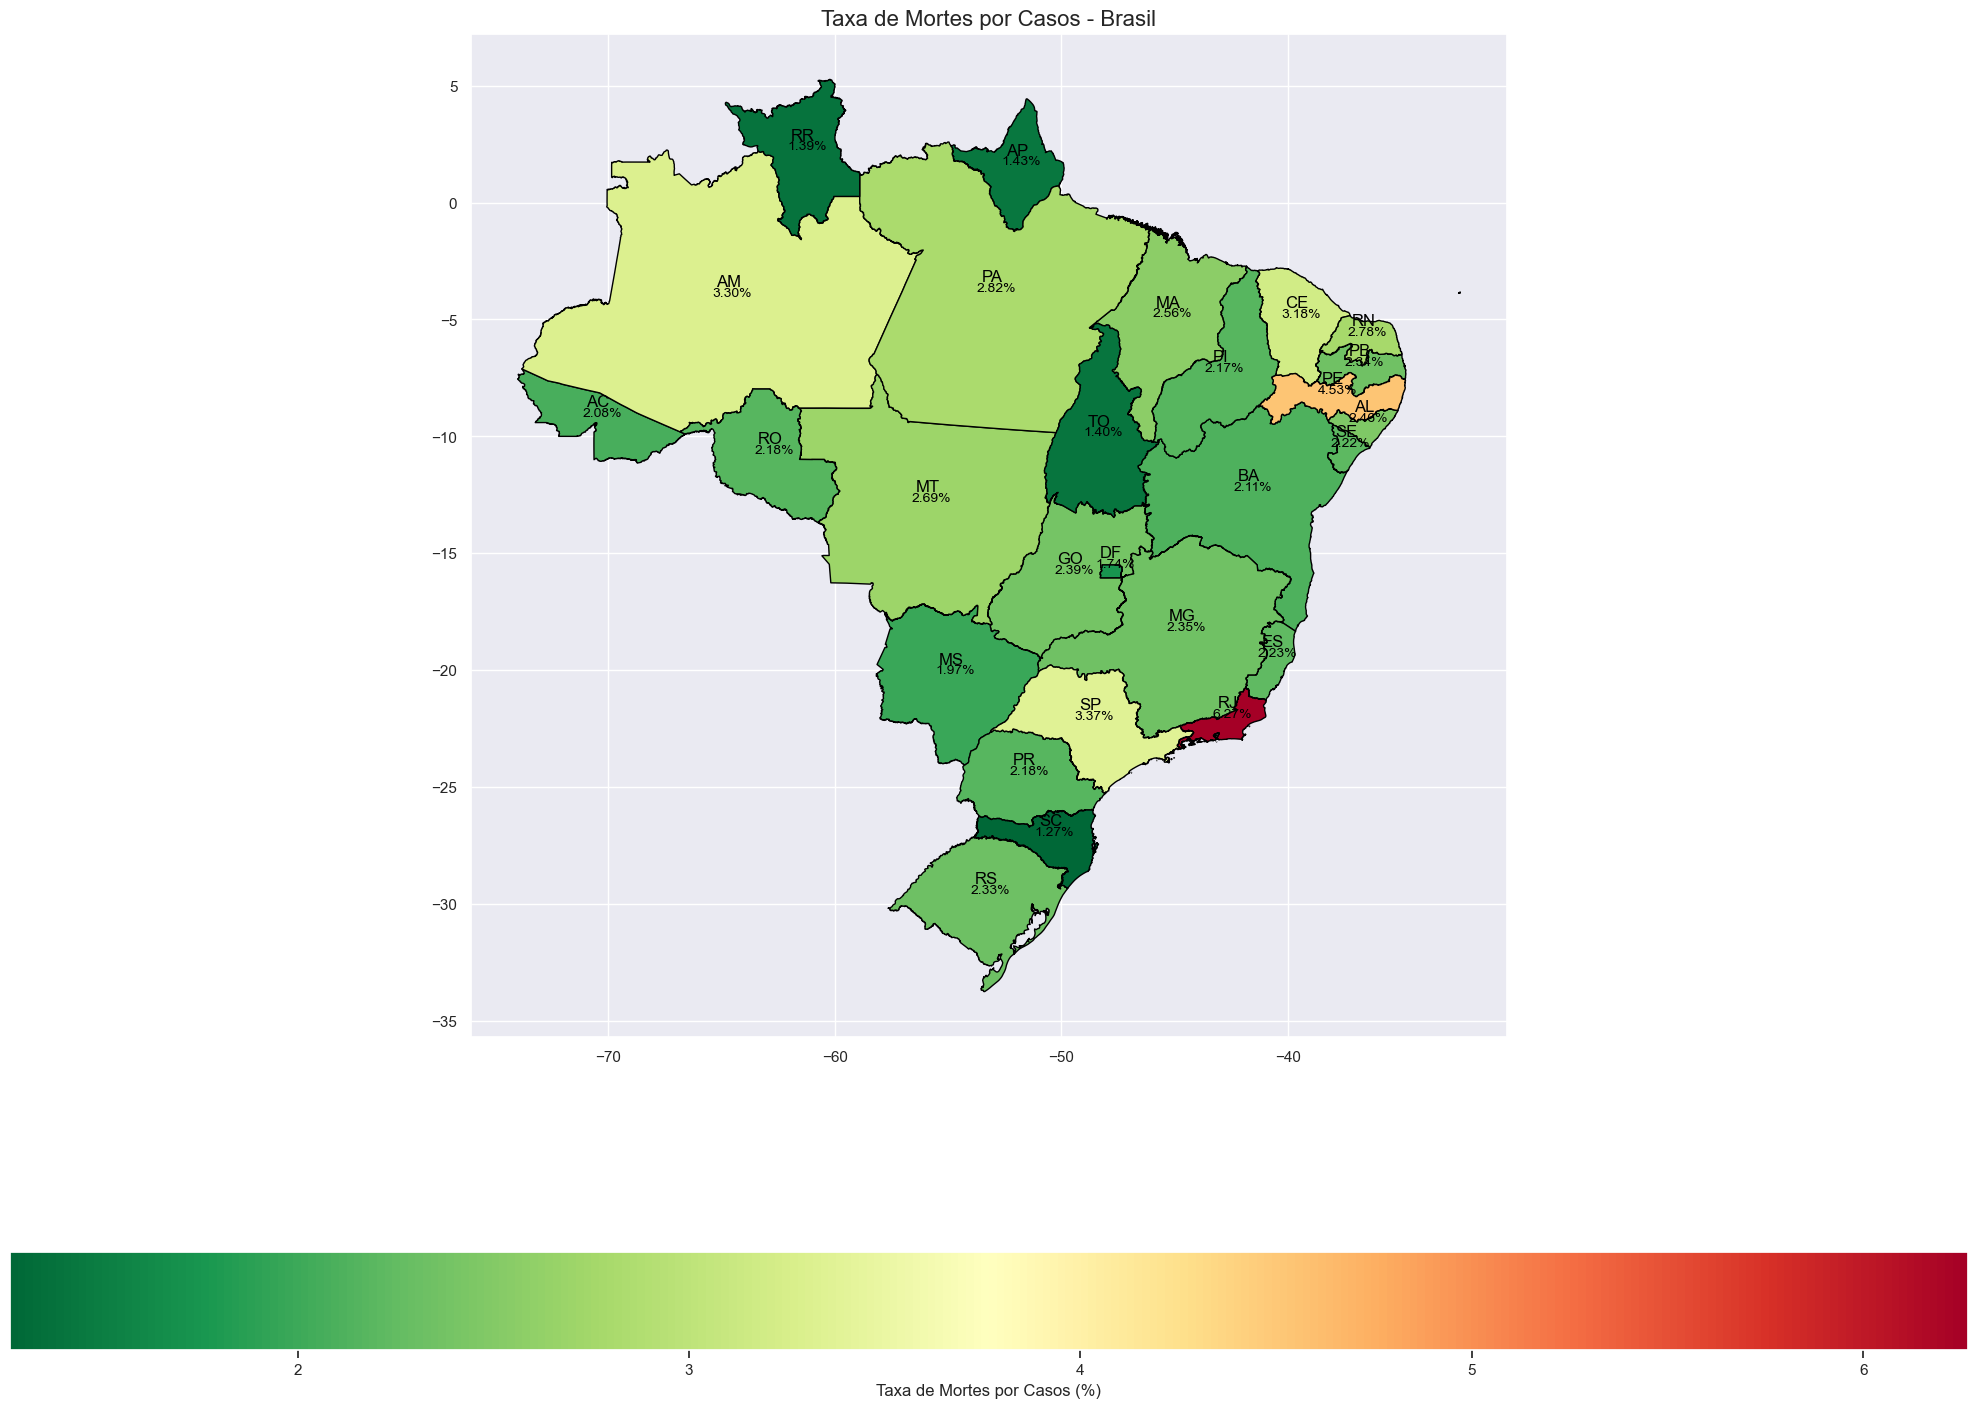

In [43]:
# Função para formatar os números
def format_number(n):
    if n >= 1_000_000:
        return f'{n / 1_000_000:.1f}MM'  # Para milhões (ex: 50.0MM)
    elif n >= 1_000:
        return f'{n / 1_000:.1f}K'  # Para milhares (ex: 50.0K)
    else:
        return str(n)  # Para valores menores que 1.000

# Carregando o mapa do Brasil com Geopandas
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf = gpd.read_file(url)

# Unindo os dados de casos com os dados de geolocalização dos estados
gdf = gdf.set_index('sigla').join(df_raw_states_cross_section.set_index('state'))

# Plotando o mapa
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plotando o mapa com cores que variam de verde (menos casos) a vermelho (mais casos)
gdf.plot(column='cases', ax=ax, legend=True,
         legend_kwds={'label': "Total de Casos por Estado",
                      'orientation': "horizontal"},
         cmap='RdYlGn_r', edgecolor='black')

# Adicionando o número de casos em cada estado
for idx, row in gdf.iterrows():
    # Obtendo o centroide de cada estado
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    
    # Formatando o número de casos
    formatted_cases = format_number(row['cases'])
    
    # Adicionando o número de casos no centroide do estado
    ax.annotate(f'{formatted_cases}', xy=(x, y), xytext=(3, 3), textcoords="offset points",
                fontsize=10, color='black', ha='center')

    # Adicionando a sigla do estado no centroide
    ax.annotate(f'{row.name}', xy=(x, y), xytext=(0, 10), textcoords="offset points",
                fontsize=12, color='black', ha='center')

# Adicionando o título
ax.set_title("Distribuição de Casos por Estado - Brasil", fontsize=16)

# Exibindo o mapa
plt.tight_layout()
plt.show()

# Carregando o mapa do Brasil com Geopandas
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
gdf = gpd.read_file(url)

# Unindo os dados de taxas com os dados de geolocalização dos estados
gdf = gdf.set_index('sigla').join(df_raw_states_cross_section.set_index('state'))

# Plotando o mapa
fig, ax = plt.subplots(1, 1, figsize=(20, 15))

# Plotando o mapa com cores que variam de verde (menor taxa) a vermelho (maior taxa)
gdf.plot(column='tax_deaths_per_cases', ax=ax, legend=True,
         legend_kwds={'label': "Taxa de Mortes por Casos (%)",
                      'orientation': "horizontal"},
         cmap='RdYlGn_r', edgecolor='black')

# Adicionando a taxa de mortes por caso em cada estado
for idx, row in gdf.iterrows():
    # Obtendo o centroide de cada estado
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    
    # Formatando a taxa de mortes
    formatted_rate = f'{row["tax_deaths_per_cases"]:.2f}%'
    
    # Adicionando a taxa de mortes no centroide do estado
    ax.annotate(f'{formatted_rate}', xy=(x, y), xytext=(3, 3), textcoords="offset points",
                fontsize=10, color='black', ha='center')

    # Adicionando a sigla do estado no centroide
    ax.annotate(f'{row.name}', xy=(x, y), xytext=(0, 10), textcoords="offset points",
                fontsize=12, color='black', ha='center')

# Adicionando o título
ax.set_title("Taxa de Mortes por Casos - Brasil", fontsize=16)

# Exibindo o mapa
plt.tight_layout()
plt.show()

# <font color='green' style='font-size: 30px;'> 2.2) Existem diferenças significativas nas taxas de mortalidade para os estados?​ </font>
<hr style='border: 2px solid green;'>

# <font color='green' style='font-size: 30px;'> 2.3) Como se comporta o número de casos, mortes e a taxa de mortalidade ao longo do período analisado? </font>
<hr style='border: 2px solid green;'>

> 1. Ao longo do tempo, os casos e as mortes crescem em número absoluto, mas a Taxa de Mortalidade tem um pico no início e foi estabilizando ao longo do tempo

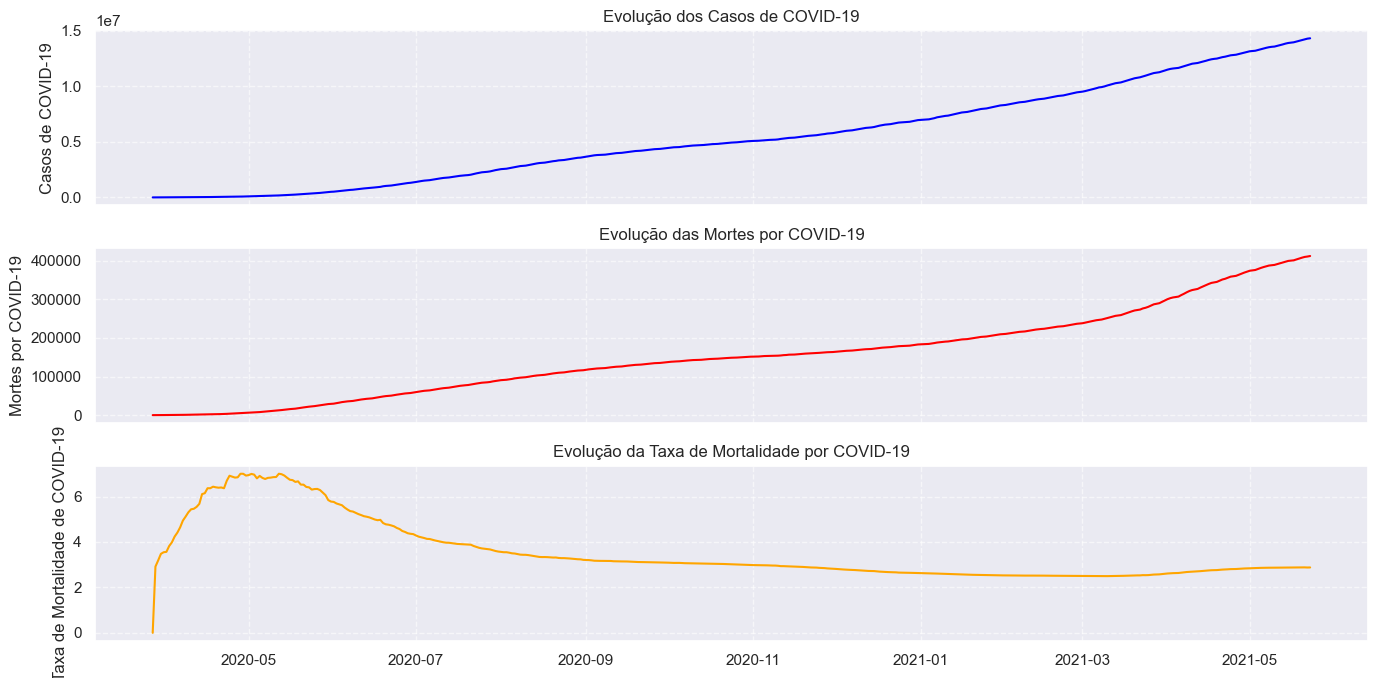

In [61]:
# Criando a figura e os subplots
fig, ax = plt.subplots(3, 1, figsize=(14, 7), sharex=True)  # 3 linhas, 1 coluna

# Gráfico de Casos
ax[0].plot(df_raw_time_series['date'], df_raw_time_series['cases'], linestyle='-', color='blue')
ax[0].set_ylabel("Casos de COVID-19")
ax[0].set_title("Evolução dos Casos de COVID-19")
ax[0].grid(True, linestyle="--", alpha=0.6)

# Gráfico de Mortes
ax[1].plot(df_raw_time_series['date'], df_raw_time_series['deaths'], linestyle='-', color='red')
ax[1].set_ylabel("Mortes por COVID-19")
ax[1].set_title("Evolução das Mortes por COVID-19")
ax[1].grid(True, linestyle="--", alpha=0.6)


# Gráfico de Taxa de Mortes
ax[2].plot(df_raw_time_series['date'], df_raw_time_series['tax_deaths_per_cases'], linestyle='-', color='orange')
ax[2].set_ylabel("Taxa de Mortalidade de COVID-19")
ax[2].set_title("Evolução da Taxa de Mortalidade por COVID-19")
ax[2].grid(True, linestyle="--", alpha=0.6)


# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()


# <font color='green' style='font-size: 30px;'> 2.4) Quais os 5 estados que apresentaram a melhoria mais significativa nas taxas de mortalidade ao longo do período analisado? </font>
<hr style='border: 2px solid green;'>

> 1. Embora todos tenham picos no início e tendam à estabilidade conforme o passar do tempo, as séries se comportam de maneiras distintas a depender da Região.

> 2. Isso significa que existe ao menos um padrão visual entre as séries de estados que estão na mesma região, levando a crer que talvez seja melhor criar um modelo para cada região

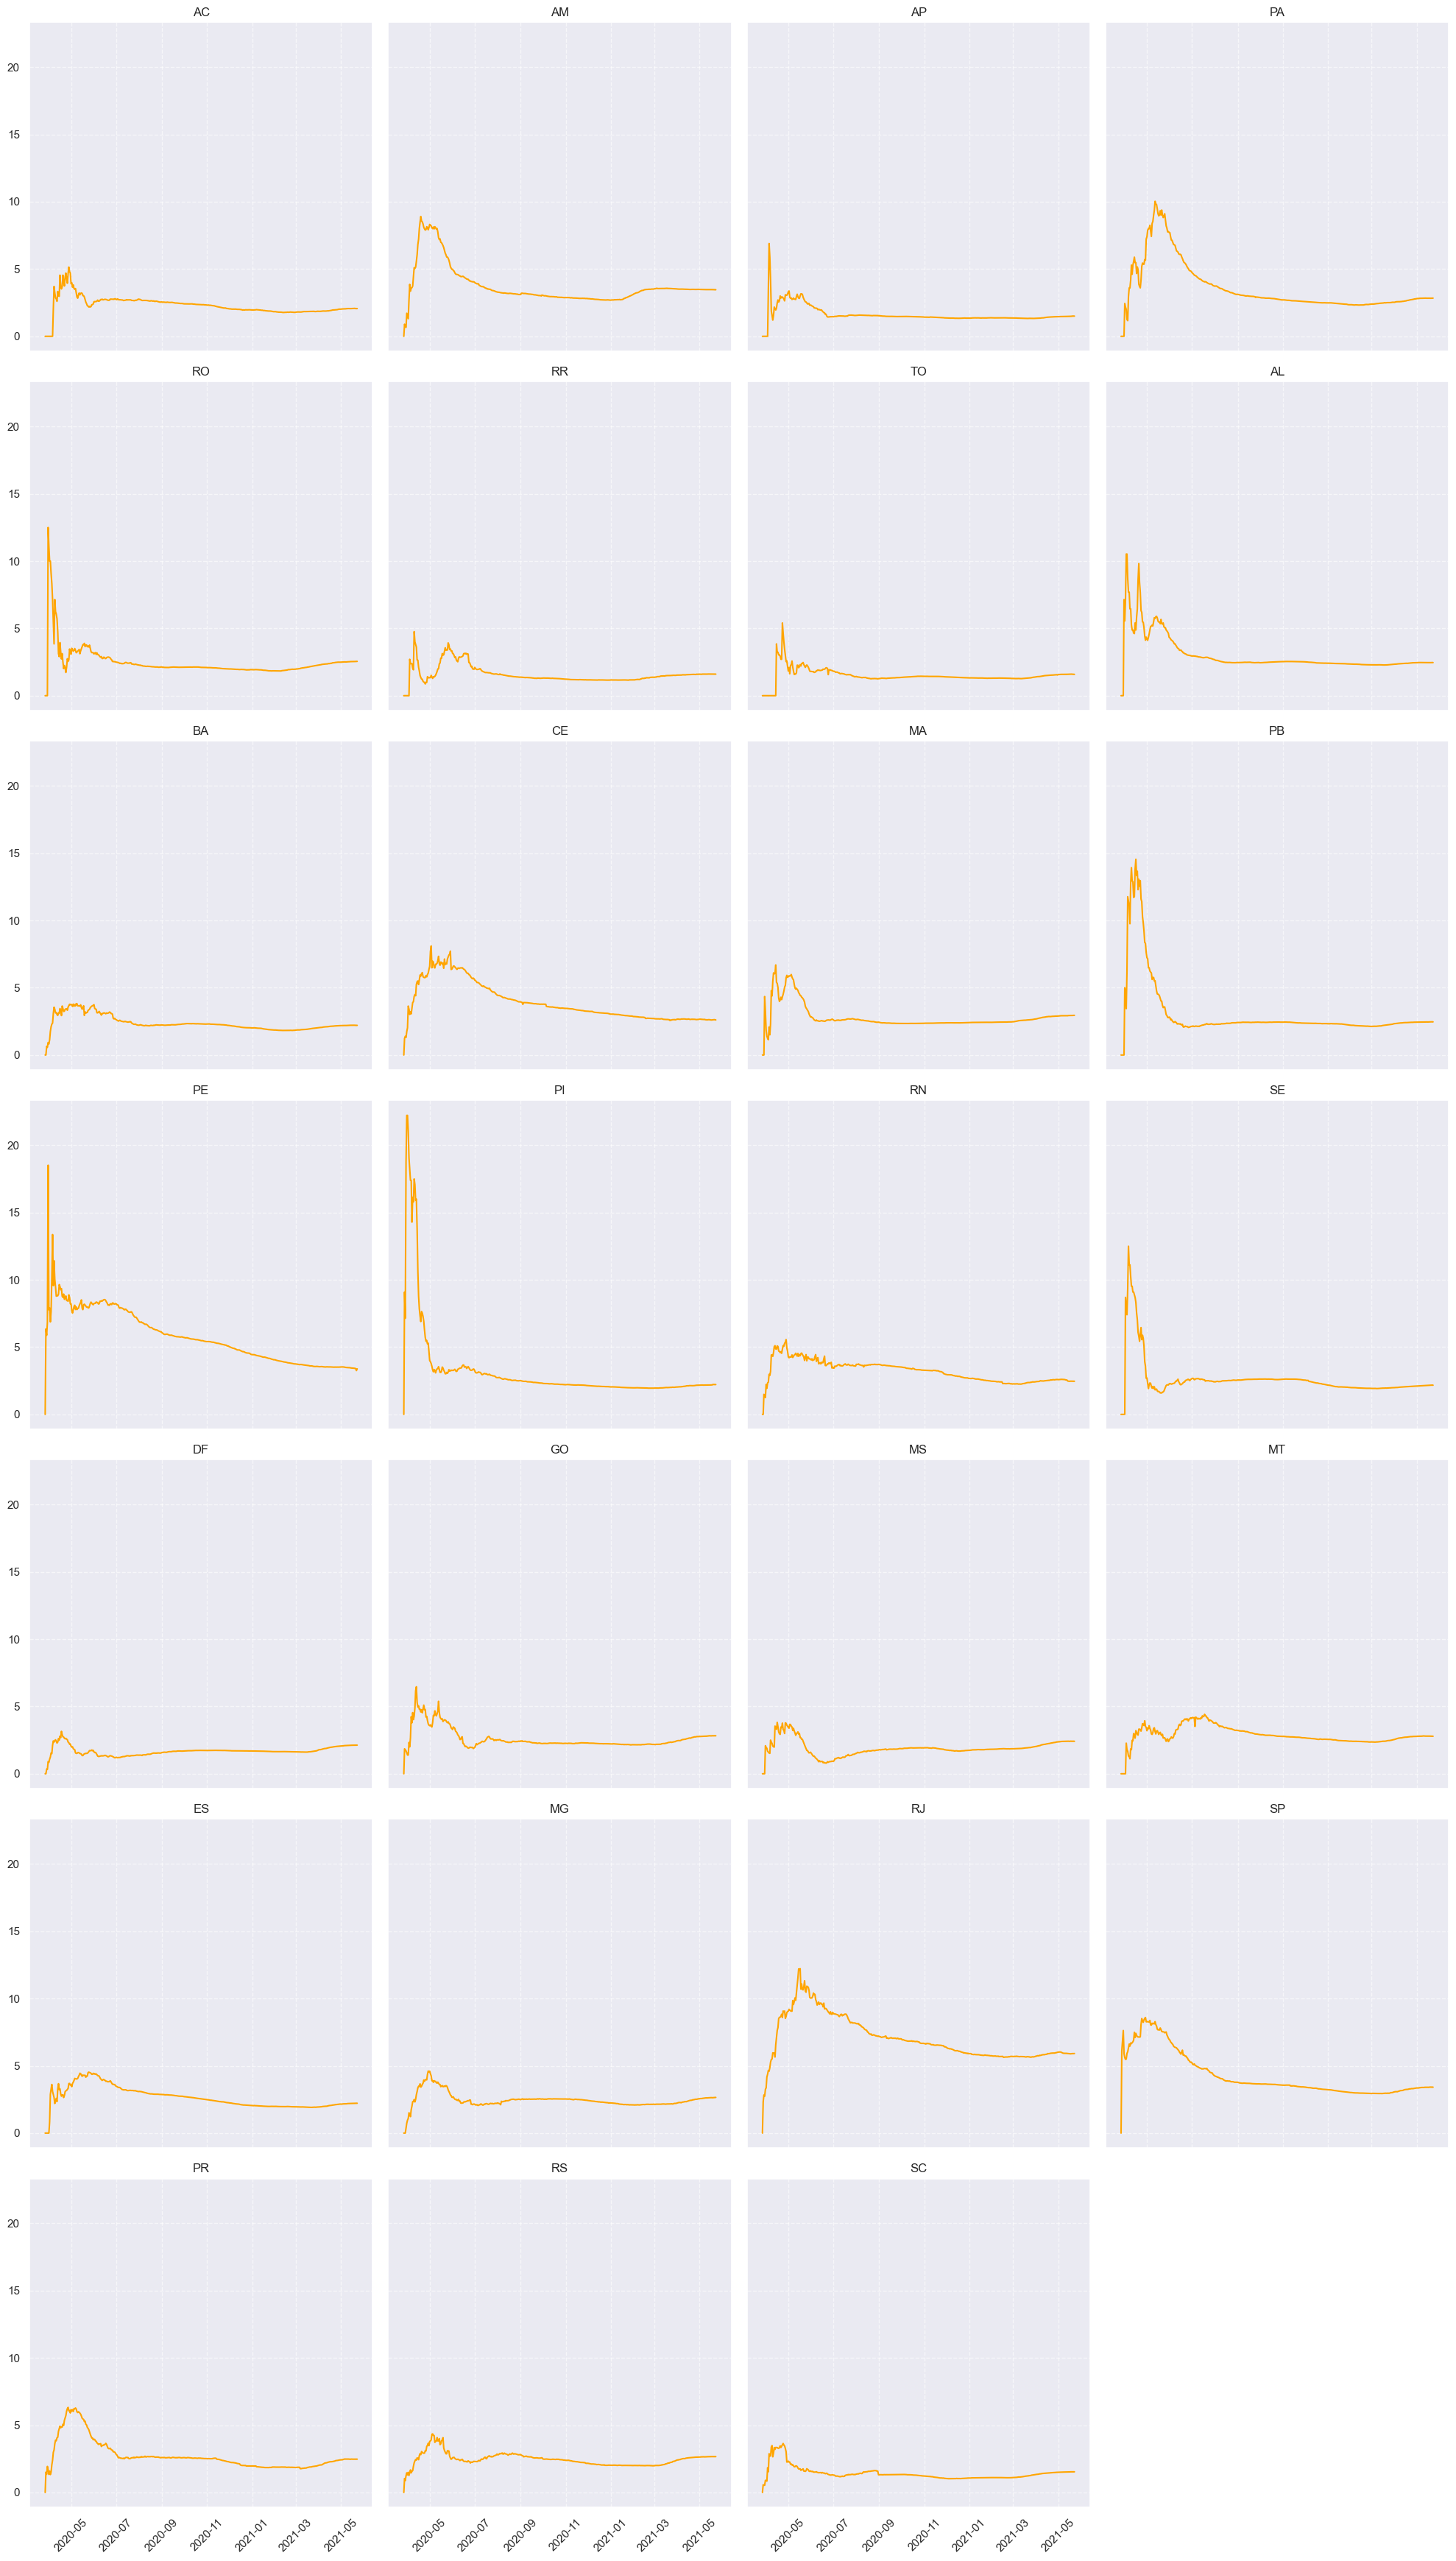

In [62]:
# Dicionário de estados e suas respectivas regiões
regioes = {
    'Norte': ['AC', 'AP', 'AM', 'PA', 'RO', 'RR', 'TO'],
    'Nordeste': ['AL', 'BA', 'CE', 'MA', 'PB', 'PE', 'PI', 'RN', 'SE'],
    'Centro-Oeste': ['DF', 'GO', 'MT', 'MS'],
    'Sudeste': ['ES', 'MG', 'RJ', 'SP'],
    'Sul': ['PR', 'RS', 'SC']
}

# Criar uma lista ordenada de estados por região
estados_ordenados = []
for regiao in regioes.keys():
    estados_na_regiao = [estado for estado in regioes[regiao] if estado in df_raw_time_series_states['state'].unique()]
    estados_ordenados.extend(sorted(estados_na_regiao))  # Ordena alfabeticamente dentro da região

# Definir número de colunas e calcular o número de linhas necessárias
num_colunas = 4  # Ajuste conforme necessário
num_linhas = int(np.ceil(len(estados_ordenados) / num_colunas))  # Calcula o número de linhas

# Criar a figura e os subplots
fig, ax = plt.subplots(num_linhas, num_colunas, figsize=(20, 5 * num_linhas), sharex=True, sharey=True)

# Transformar o array 2D em lista para facilitar a indexação
ax = ax.flatten()

# Criar gráficos para cada estado na ordem correta
for i, estado in enumerate(estados_ordenados):
    df_estado = df_raw_time_series_states[df_raw_time_series_states['state'] == estado]

    ax[i].plot(df_estado['date'], df_estado['tax_deaths_per_cases'], linestyle='-', color='orange')
    ax[i].set_title(f"{estado}")
    ax[i].grid(True, linestyle="--", alpha=0.6)

    # Melhorando a formatação do eixo X
    ax[i].tick_params(axis='x', rotation=45)

# Remover gráficos vazios se houver menos estados que subplots
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

# Ajusta o layout para evitar sobreposição
plt.tight_layout()

# Exibir o gráfico
plt.show()

# <font color='green' style='font-size: 30px;'> 2.5) Em relação ao Brasil, como se comportam as componentes temporais da série histórica? </font>
<hr style='border: 2px solid green;'>

# <font color='red' style='font-size: 40px;'> 3) Feature Engineering </font>
<hr style='border: 2px solid red;'>

# <font color='red' style='font-size: 40px;'> 4) Modelagem </font>
<hr style='border: 2px solid red;'>

In [12]:
# df_raw_groupped = df_raw.groupby(['Date', 'Country/Region']).agg({
#     "Lat": "max", 
#     "Long": "max", 
#     "Confirmed": "sum", 
#     "Recovered": "sum", 
#     "Deaths": "sum"
# }).reset_index()

In [13]:
# plt.figure(figsize=(16,8))
# ax = plt.subplot(1,2,1)
# ax.set_title('Casos Acumulados', fontsize=18, loc='left')
# plt.plot(df_brazil['Brazil'], label='Brazil')
# plt.plot(df_conf_w['Argentina'], label='Argentina')
# plt.plot(df_conf_w['Uruguay'], label='Uruguay')
# plt.xlabel("Dia")
# plt.ylabel("Casos")
# plt.legend();
# ax = plt.subplot(1,2,2)
# ax.set_title('Óbitos Acumulados', fontsize=18, loc='left')
# plt.plot(df_brazil['Brazil'], label='Brazil')
# plt.plot(df_deaths_w['Argentina'], label='Argentina')
# plt.plot(df_deaths_w['Uruguay'], label='Uruguay')
# plt.xlabel("Dia")
# plt.ylabel("Óbitos")
# plt.legend()